In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import EuroSAT
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import time
import numpy as np
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()


Total dataset size: 27000
Train size: 21600, Test size: 5400
Available labels: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


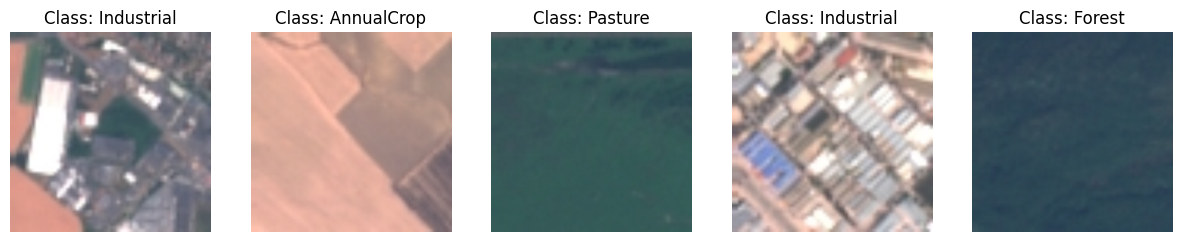

In [2]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # match ResNet input size
    transforms.ToTensor(),
])

# Load dataset
dataset = EuroSAT(root="./data", transform=transform, download=True)

# Dataset split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"Total dataset size: {len(dataset)}")
print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")

# Show available labels
print(f"Available labels: {dataset.classes}")

# Show some images
# Show example images
def show_images(dataset, n=5):
    fig, axs = plt.subplots(1, n, figsize=(15, 5))
    for i in range(n):
        img, label = dataset[i]
        axs[i].imshow(img.permute(1, 2, 0))
        axs[i].set_title(f"Class: {dataset.dataset.classes[label]}")
        axs[i].axis("off")
    plt.show()
show_images(train_dataset, n=5)


In [3]:
import torch.nn as nn
import torch.nn.functional as F

class CNNWithBatchNorm(nn.Module):
    def __init__(self, num_classes):
        super(CNNWithBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [4]:
def train_model(model, train_loader, test_loader, epochs=5, lr=0.001):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            del images, labels, outputs, loss
            torch.cuda.empty_cache()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

    # Evaluate
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            del images, labels, outputs, preds
            torch.cuda.empty_cache()
    
    end_time = time.time()
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Training time: {end_time - start_time:.2f} seconds")
    del model
    torch.cuda.empty_cache()
    return accuracy, end_time - start_time


In [5]:
from torchvision.models import resnet18

def get_resnet_model(num_classes, finetune=False):
    model = resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = finetune
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


In [6]:
from torchvision.models import efficientnet_b0

def get_efficientnet_model(num_classes, finetune=False):
    model = efficientnet_b0(pretrained=True)
    for param in model.parameters():
        param.requires_grad = finetune
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model


In [7]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
num_classes = len(dataset.classes)
results = {}

print("\n🔧 Training CNN from scratch:")
cnn_model = CNNWithBatchNorm(num_classes=num_classes)
acc, t = train_model(cnn_model, train_loader, test_loader)
results["CNN Scratch"] = (acc, t)    



🔧 Training CNN from scratch:
Epoch 1/5, Loss: 2.2670
Epoch 2/5, Loss: 1.2349
Epoch 3/5, Loss: 1.0421
Epoch 4/5, Loss: 0.8355
Epoch 5/5, Loss: 0.7324
Test Accuracy: 66.33%
Training time: 633.80 seconds


In [8]:
print("\n🧠 ResNet18 as feature extractor:")
resnet_feat = get_resnet_model(num_classes=num_classes, finetune=False)
acc, t = train_model(resnet_feat, train_loader, test_loader)
results["ResNet18 Frozen"] = (acc, t)


🧠 ResNet18 as feature extractor:


/home/lr/.cache/pypoetry/virtualenvs/ailab-M5MNRa5y-py3.13/lib64/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lr/.cache/pypoetry/virtualenvs/ailab-M5MNRa5y-py3.13/lib64/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 0.5839
Epoch 2/5, Loss: 0.3669
Epoch 3/5, Loss: 0.3378
Epoch 4/5, Loss: 0.3201
Epoch 5/5, Loss: 0.3116
Test Accuracy: 91.39%
Training time: 213.18 seconds


In [9]:
print("\n🧠 ResNet18 fine-tuned:")
resnet_fine = get_resnet_model(num_classes=num_classes, finetune=True)
acc, t = train_model(resnet_fine, train_loader, test_loader, lr=0.0001)
results["ResNet18 Fine-tuned"] = (acc, t)



🧠 ResNet18 fine-tuned:
Epoch 1/5, Loss: 0.2504
Epoch 2/5, Loss: 0.1161
Epoch 3/5, Loss: 0.0780
Epoch 4/5, Loss: 0.0634
Epoch 5/5, Loss: 0.0576
Test Accuracy: 97.80%
Training time: 533.07 seconds


In [10]:

print("\n🚀 EfficientNet_B5 as feature extractor:")
eff_feat = get_efficientnet_model(num_classes=num_classes, finetune=False)
acc, t = train_model(eff_feat, train_loader, test_loader)
results["EfficientNet_B5 Frozen"] = (acc, t)


/home/lr/.cache/pypoetry/virtualenvs/ailab-M5MNRa5y-py3.13/lib64/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /home/lr/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth



🚀 EfficientNet_B5 as feature extractor:


100%|██████████| 20.5M/20.5M [00:02<00:00, 8.11MB/s]


Epoch 1/5, Loss: 0.5804
Epoch 2/5, Loss: 0.4118
Epoch 3/5, Loss: 0.3880
Epoch 4/5, Loss: 0.3837
Epoch 5/5, Loss: 0.3700
Test Accuracy: 92.33%
Training time: 304.99 seconds


In [11]:
print("\n🚀 EfficientNet_B5 fine-tuned:")
eff_fine = get_efficientnet_model(num_classes=num_classes, finetune=True)
acc, t = train_model(eff_fine, train_loader, test_loader, lr=0.0001)
results["EfficientNet_B5 Fine-tuned"] = (acc, t)



🚀 EfficientNet_B5 fine-tuned:
Epoch 1/5, Loss: 0.3564
Epoch 2/5, Loss: 0.1181
Epoch 3/5, Loss: 0.0750
Epoch 4/5, Loss: 0.0559
Epoch 5/5, Loss: 0.0436
Test Accuracy: 98.02%
Training time: 914.74 seconds


In [12]:
# Final comparison
print("\n📊 Results Comparison:")
for k, (acc, t) in results.items():
    print(f"{k}: Accuracy = {acc:.2f}%, Time = {t:.2f}s")



📊 Results Comparison:
CNN Scratch: Accuracy = 66.33%, Time = 633.80s
ResNet18 Frozen: Accuracy = 91.39%, Time = 213.18s
ResNet18 Fine-tuned: Accuracy = 97.80%, Time = 533.07s
EfficientNet_B5 Frozen: Accuracy = 92.33%, Time = 304.99s
EfficientNet_B5 Fine-tuned: Accuracy = 98.02%, Time = 914.74s
